In [1]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
!unzip /content/drive/MyDrive/AlignedCroppedImages.zip

Streaming output truncated to the last 5000 lines.
  inflating: AlignedCroppedImages/val/Positive/pos_332_0.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_332_1.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_332_2.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_332_3.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_332_4.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_332_5.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_333_0.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_333_1.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_334_0.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_334_1.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_334_2.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_334_3.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_334_4.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_334_5.jpg  
  inflating: AlignedCroppedImages/val/Positive/pos_334_6.jpg  
  in

In [4]:
TrianImage="/content/AlignedCroppedImages/train/"
TestImage="/content/AlignedCroppedImages/test/"
Positiveimages = os.listdir(TrianImage + "/Positive")
Negativeimages = os.listdir(TrianImage + "/Negative")
Neutralimages = os.listdir(TrianImage + "/Neutral")

In [5]:
print(len(Positiveimages), len(Negativeimages), len(Neutralimages))
NUM_TRAINING_IMAGES = len(Positiveimages) + len(Negativeimages) + len(Neutralimages)
print(NUM_TRAINING_IMAGES)

35676 29207 28624
93507


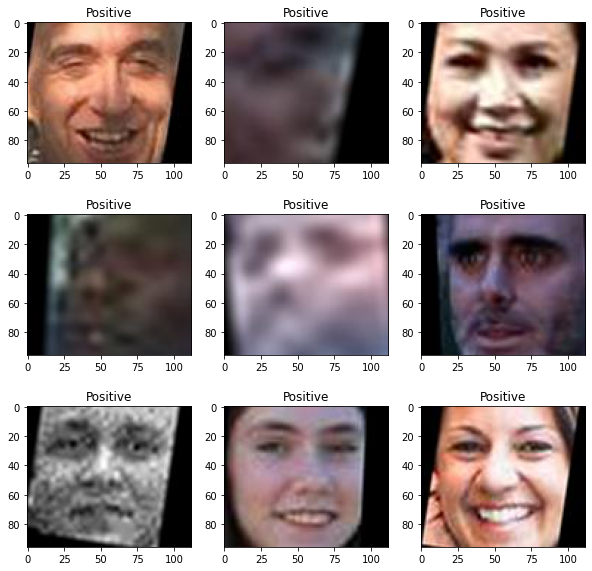

In [6]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Positive",Positiveimages[i])),cmap='gray')
    plt.title("Positive")
plt.show()

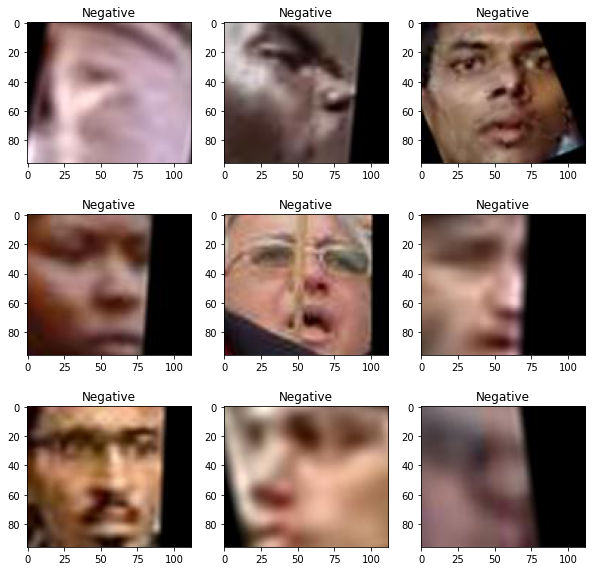

In [7]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Negative",Negativeimages[i])),cmap='gray')
    plt.title("Negative")
plt.show()

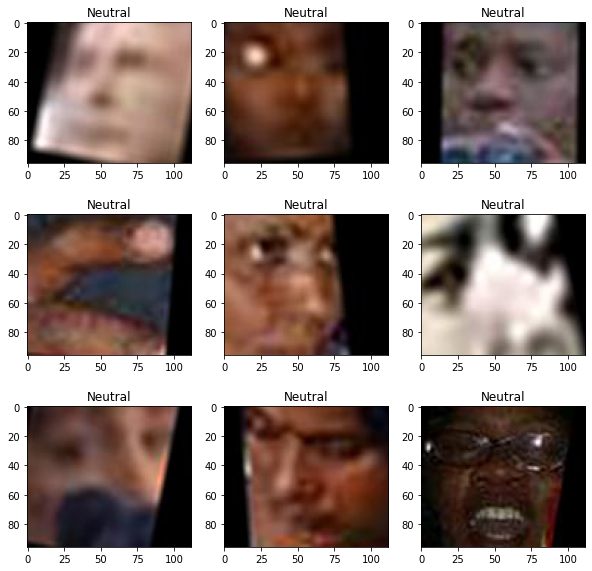

In [8]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Neutral",Neutralimages[i])),cmap='gray')
    plt.title("Neutral")
plt.show()

# Dataset

In [9]:

# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

image_size = 224 
BATCH_SIZE = 64
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '/content/AlignedCroppedImages' #/content/drive/MyDrive/salam #/content/AlignedCroppedImages

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = validation_datagen.flow_from_directory(data_path + '/val',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 93507 images belonging to 3 classes.
Found 37078 images belonging to 3 classes.


In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (64, 224, 224, 3)
test batch  (64, 224, 224, 3)
sample train label 
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [11]:
training_set.class_indices

{'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [12]:
testing_set.class_indices

{'Negative': 0, 'Neutral': 1, 'Positive': 2}

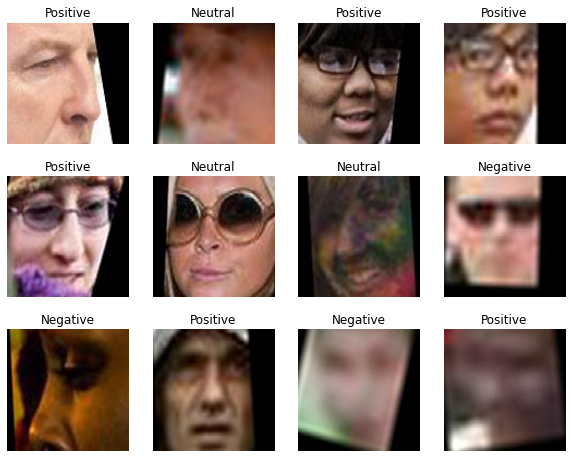

In [13]:

labels = ['Positive', 'Negative', 'Neutral']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [14]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 51kB 3.1MB/s 


In [15]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [16]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [17]:

# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [18]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [19]:

# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [20]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.2214879994521861, 1: 1.2463666852990498, 2: 1.0}

In [21]:
# dfault input shapes 

print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape)

82526208/82524592 [==============================] - 1s 0us/step
(None, 224, 224, 3)
268320768/268317848 [==============================] - 6s 0us/step
(None, 600, 600, 3)
553467904/553467096 [==============================] - 3s 0us/step
(None, 224, 224, 3)


# Pretrained Densenet

In [22]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

74842112/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.416052 to fit



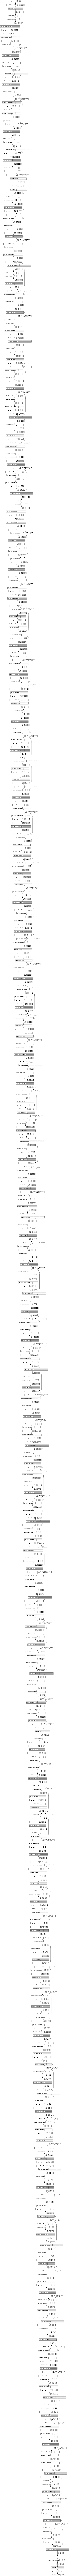

In [23]:
plot_model(model_densenet, show_shapes=True, to_file='model_densenet.png')

In [24]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=30)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1462/1462 [==============================] - 1083s 714ms/step - loss: 1.0680 - accuracy: 0.4322 - val_loss: 1.0123 - val_accuracy: 0.5030
Epoch 2/30
1462/1462 [==============================] - 1037s 709ms/step - loss: 1.0195 - accuracy: 0.4840 - val_loss: 0.9990 - val_accuracy: 0.5107
Epoch 3/30
1462/1462 [==============================] - 1037s 710ms/step - loss: 1.0097 - accuracy: 0.4971 - val_loss: 0.9879 - val_accuracy: 0.5272
Epoch 4/30
1462/1462 [==============================] - 1040s 711ms/step - loss: 1.0021 - accuracy: 0.5047 - val_loss: 0.9865 - val_accuracy: 0.5259
Epoch 5/30
1462/1462 [==============================] - 1047s 716ms/step - loss: 0.9992 - accuracy: 0.5055 - val_loss: 0.9871 - val_accuracy: 0.5223
Epoch 6/30
1462/1462 [==============================] - 1048s 717ms/step - loss: 0.9959 - accuracy: 0.5118 - val_loss: 0.9796 - val_accuracy: 0.5325
Epoch 7/30
1462/1462 [==============================] - 1048s 717ms/step - loss: 0.9906 - accuracy: 0.5154

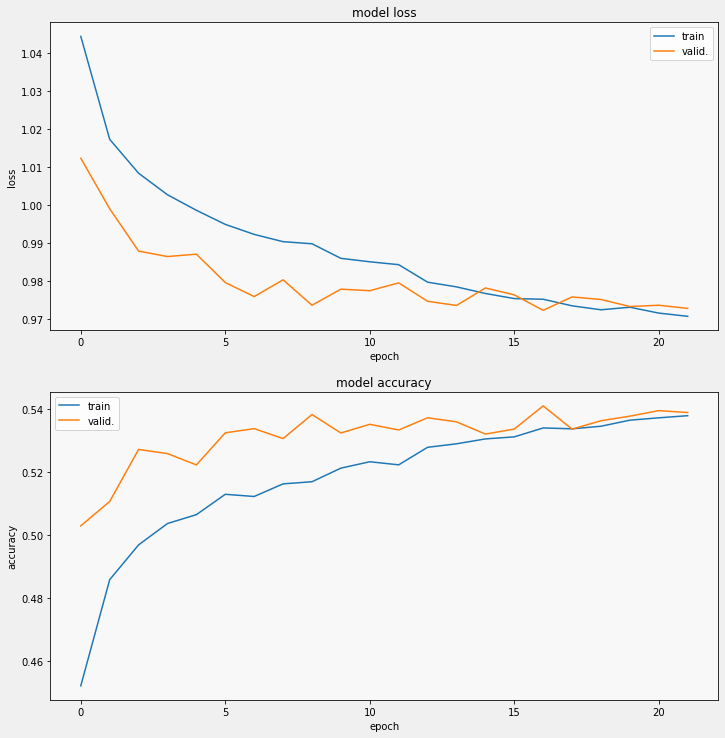

In [25]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

In [26]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

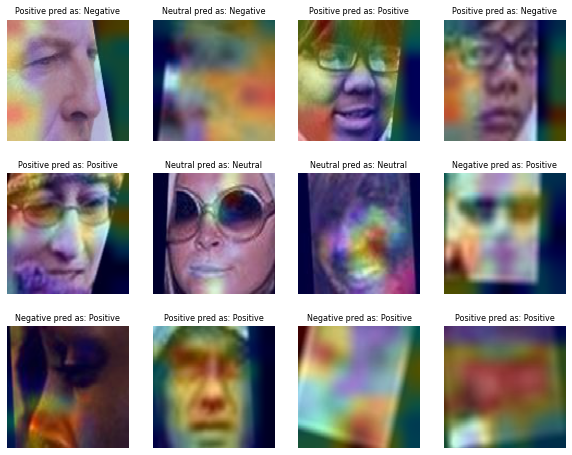

In [27]:
 #sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [28]:
model_densenet.save("model_densenet_30_09596.h5")